In [1]:
from data.preprocessing import *
from data.dataset import BERTDataset
from torch.utils.data import DataLoader

d:\R2G\OpenAI\llm_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Explore MovieDialogs Corpus

In [2]:
corpus_movie_conv = 'datasets/cornell movie-dialogs corpus/movie_conversations.txt'
corpus_movie_lines = 'datasets/cornell movie-dialogs corpus/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()
print(f"Example text in movie_lines.txt:\n{lines[0]}{lines[1]}")
print(f"Example text in movie_converstations.txt:\n{conv[0]}{conv[1]}")


# movie_lines structure
# line_id +++$+++ character_id +++$+++ movie_id +++$+++ character_name(?) +++$+++ conversation line

# movie_conversations structure
# character_id +++$+++ reply_to_id (spoken to) +++$+++ movie_id +++$+++ line_ids

Example text in movie_lines.txt:
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

Example text in movie_converstations.txt:
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']



In [3]:
pairs, lines_dict = prepare_qa_pairs(lines, conv)

Skipping L474 as it's missing text: ['L474', 'u5', 'm0', 'KAT +++$+++']
Skipping L24609 as it's missing text: ['L24609', 'u224', 'm14', 'SYKES +++$+++']
Skipping L239088 as it's missing text: ['L239088', 'u1125', 'm74', 'JANOSZ +++$+++']
Skipping L283548 as it's missing text: ['L283548', 'u1356', 'm90', 'BRUCE +++$+++']


##### WordPiece tokenizer

In [15]:
# BERT uses WordPiece embeddings with 30k token vocabulary
# The first token of every sequence is always a special classification token ([CLS])
# Sentence pairs are packed together into a single sequence.
# They are separated with special token ([SEP]), also a learned embedding is added to every token, which indicates if it belongs to sentence A or Sentence B

In [ ]:
prepare_text_batches(pairs)

100%|██████████| 221282/221282 [00:00<00:00, 4338852.68it/s]


In [ ]:
chunk_paths = [os.path.join('./datasets/MovieDialogsChunks/', x) for x in os.listdir('./datasets/MovieDialogsChunks')]
train_tokenizer(chunk_paths)

#### Validate pre-training data prep

In [5]:
tokenizer = BertTokenizer.from_pretrained('./bert_tokenizer/bert-movie_corp-vocab.txt', local_files_only=True)
data = BERTDataset(pairs, tokenizer=tokenizer)

d:\R2G\OpenAI\llm_venv\Lib\site-packages\transformers\tokenization_utils_base.py:1945: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [6]:
print(f"Data extracted by get_sentence_pair method:\n{data.get_sentence_pair(0)}")
print(f"Corresponding pair:\n{pairs[0]}")

Data extracted by get_sentence_pair method:
('Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.', "Well, I thought we'd start with pronunciation, if that's okay with you.")
Corresponding pair:
['Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.', "Well, I thought we'd start with pronunciation, if that's okay with you."]


In [7]:
print(f"Randomly picked sentence2:\n{data.get_random_line()}")

Randomly picked sentence2:
They still hang women in Canada, I've heard.


In [8]:
data.create_sentence_pair(0)

('Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you.",
 1)

In [9]:
data.create_sentence_pair(0)

('Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.',
 'What kind of vacation?',
 0)

In [10]:
s1, s2, label = data.create_sentence_pair(0)
tokens = s1.split()
print(tokens)

['Can', 'we', 'make', 'this', 'quick?', 'Roxanne', 'Korrine', 'and', 'Andrew', 'Barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break-', 'up', 'on', 'the', 'quad.', 'Again.']


In [19]:
import random
tokens = s1.split()
output_label = []
output = []

for i, token in enumerate(tokens):
    probability = random.random()
    # Removing [CLS] and [SEP] tokens
    token_id = tokenizer(token)['input_ids'][1:-1]
    if probability < 0.15:
        probability /= 0.15
        if probability < 0.8:
            # replace ith token with [MASK] 80% of the time 
            for i in range(len(token_id)):
                output.append(tokenizer.vocab['[MASK]'])  
        elif probability < 0.9:
            # replace ith token with random token 10% of the time
            for i in range(len(token_id)):
                output.append(random.randint(0, len(tokenizer.vocab)-1))
        else:
            # keep the ith token unchanged 10% of the time
            output.append(token_id)
        output_label.append(token_id)
    else:
        output.append(token_id)
        for i in range(len(token_id)):
            output_label.append(0)

In [20]:
print(output)
print(output_label)
# Needs to be flattened into a single list
import itertools
output_flat = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
output_label_flat = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
print(output_flat)
print(output_label_flat)

[[230], [184], [432], [208], [1712, 34], [529, 118, 13347], [8260, 11002], [179], [5195], [12825], [234], [1133], [160], [6997], 2, 2, 2, [1994], 2, 2, 10082, [192], [150], [8115, 17], [542, 17]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, [4953, 19513, 313], 0, [1023, 16], [275], 0, 0, 0, 0, 0, 0]
[230, 184, 432, 208, 1712, 34, 529, 118, 13347, 8260, 11002, 179, 5195, 12825, 234, 1133, 160, 6997, 2, 2, 2, 1994, 2, 2, 10082, 192, 150, 8115, 17, 542, 17]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4953, 19513, 313, 0, 1023, 16, 275, 0, 0, 0, 0, 0, 0]


In [21]:
output_words = tokenizer.convert_ids_to_tokens(output_flat)
output_label_words = tokenizer.convert_ids_to_tokens(output_label_flat)

reconstructed_sentence_with_mask = ' '.join(output_words)

reconstructed_original_sentence = []
for token_id, label_id in zip(output_flat, output_label_flat):
    if label_id == 0:
        reconstructed_original_sentence.append(tokenizer.convert_ids_to_tokens([token_id])[0])
    else:
        reconstructed_original_sentence.append(tokenizer.convert_ids_to_tokens([label_id])[0])
reconstructed_original_sentence = ' '.join(reconstructed_original_sentence)

print(f"Actual sentence:\n{s1}\n")
print(f"Reconstructed sentence with [MASK]:\n{reconstructed_sentence_with_mask}\n")
print(f"Reconstructed original sentence:\n{reconstructed_original_sentence}")

Actual sentence:
Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.

Reconstructed sentence with [MASK]:
can we make this quick ? ro ##x ##anne kor ##rine and andrew barrett are having an incredibly [MASK] [MASK] [MASK] public [MASK] [MASK] conductor on the quad . again .

Reconstructed original sentence:
can we make this quick ? ro ##x ##anne kor ##rine and andrew barrett are having an incredibly horr ##endo ##us public break - up on the quad . again .


#### Validate BERTDataset class

In [63]:
dataset = BERTDataset(pairs, tokenizer)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)                               
sample_data = next(iter(data_loader))
idx = 23
print(sample_data['bert_input'][idx])
print(sample_data['bert_label'][idx])
print(sample_data['segment_label'][idx])
print(sample_data['is_consecutive'][idx])

tensor([    1,   276,   208,  3213,    15,    48,   316,     2,   274,   243,
           17,     4,     2,   598, 17101,  8507,   230,   409,     2,  1156,
           15,   220,  1210,   302,   184,     2,     2,     2,     2,   248,
          184,   217,   153,     2,   194,  2443,   275,   150,     2,     2,
            2,   153,   173,  1156,  5924,   146,   359,   386,   122,  1042,
          253,    15,   179,   342, 16614, 20742,   100,    15,   255,   437,
          183,  2664,   178,  3590,   153,  2365,   150,  5245,   546,   150,
         4257,    17,   268,    11,    58,   173,     2,     2,   146,    15,
         6253,    34,     4,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [69]:
print(sample_data['bert_input'][idx])
print(sample_data['bert_label'][idx])
print(sample_data['segment_label'][idx])
print(sample_data['is_consecutive'][idx])

tensor([    1,   276,   208,  3213,    15,    48,   316,     2,   274,   243,
           17,     4,     2,   598, 17101,  8507,   230,   409,     2,  1156,
           15,   220,  1210,   302,   184,     2,     2,     2,     2,   248,
          184,   217,   153,     2,   194,  2443,   275,   150,     2,     2,
            2,   153,   173,  1156,  5924,   146,   359,   386,   122,  1042,
          253,    15,   179,   342, 16614, 20742,   100,    15,   255,   437,
          183,  2664,   178,  3590,   153,  2365,   150,  5245,   546,   150,
         4257,    17,   268,    11,    58,   173,     2,     2,   146,    15,
         6253,    34,     4,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [70]:
output_words = tokenizer.convert_ids_to_tokens(sample_data['bert_input'][idx].numpy().tolist())
reconstructed_sentence_with_mask = ' '.join(output_words)

reconstructed_original_sentence = []
for token_id, label_id in zip(sample_data['bert_input'][idx], sample_data['bert_label'][idx]):
    if label_id == 0:
        reconstructed_original_sentence.append(tokenizer.convert_ids_to_tokens([token_id])[0])
    else:
        reconstructed_original_sentence.append(tokenizer.convert_ids_to_tokens([label_id])[0])
reconstructed_original_sentence = ' '.join(reconstructed_original_sentence)

print(f"Reconstructed sentence with [MASK]:\n{reconstructed_sentence_with_mask}\n")
print(f"Reconstructed original sentence:\n{reconstructed_original_sentence}")
print(sample_data['is_consecutive'][idx].numpy())

Reconstructed sentence with [MASK]:
[CLS] at this size , i would [MASK] think so . [SEP] [MASK] those corpus ##cles can take [MASK] air , no reason why we [MASK] [MASK] [MASK] [MASK] all we have to [MASK] is hook up the [MASK] [MASK] [MASK] to that air chamber you were talk ##1 ##ng about , and when benes inhale ##s , there should be plenty of pressure to force the oxygen into the tank . how ' s that [MASK] [MASK] you , skipper ? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

#### Embedding validation

In [150]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.getcwd())) 
sys.path.insert(0, root_dir)

# model_dir = os.path.abspath(os.path.join(os.getcwd(),  'model')) 
# sys.path.insert(0, model_dir)
import importlib
from model import layers
importlib.reload(layers) 
from model.layers import BERTEmbedding

from config import SEQ_LEN
embeddings_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=SEQ_LEN, debug=True)
embedding, pos_emb_test = embeddings_layer(sample_data["bert_input"], sample_data["segment_label"])
print(embedding.shape)

torch.Size([32, 256, 768])


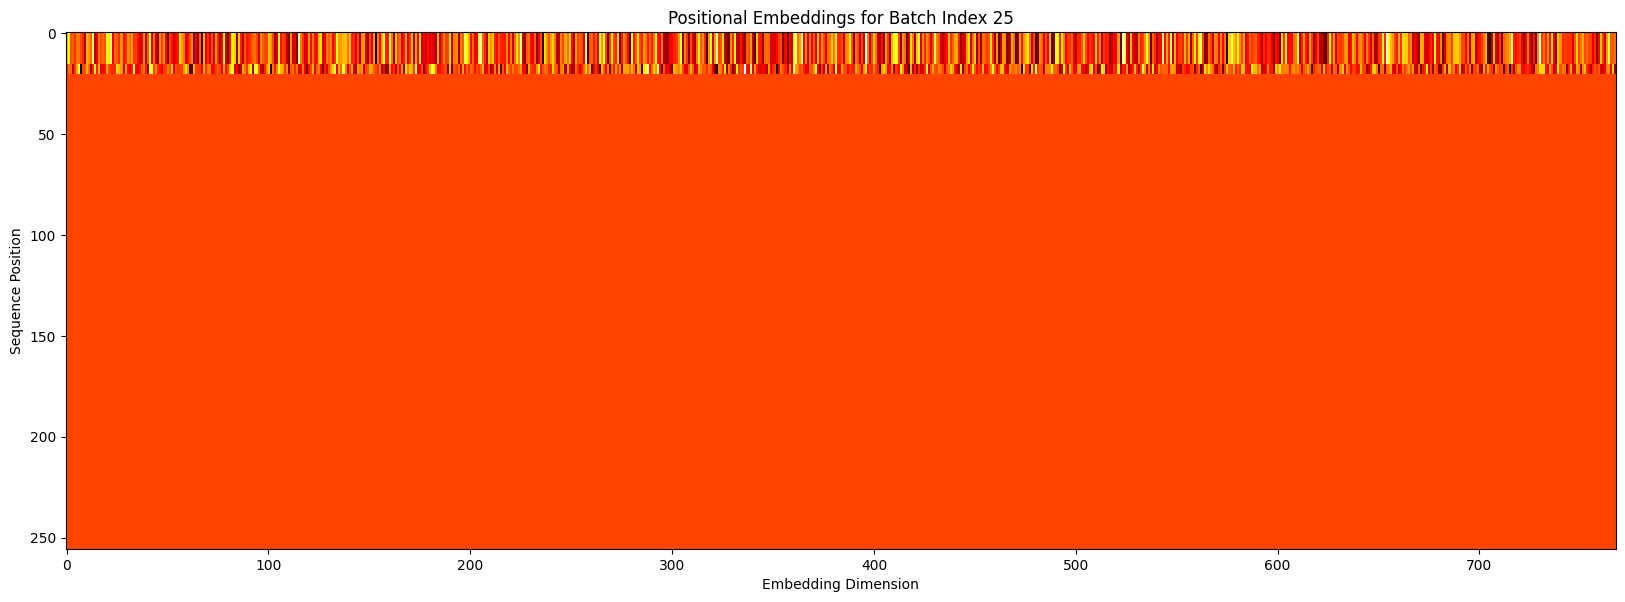

In [151]:
import matplotlib.pyplot as plt
# Shape: (batch_size, seq_len, embed_size)
batch_index = 25
pos_emb_np = pos_emb_test.detach().numpy()
plt.figure(figsize=(20, 12))
plt.imshow(pos_emb_np[batch_index, :, :], cmap='hot', interpolation='nearest')
plt.title(f'Positional Embeddings for Batch Index {batch_index}')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.show()